In [351]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
from scipy.stats import *
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns # informative statistical graphics.
import statsmodels.api as sm #for ARIMA and SARIMAX
import datetime
from datetime import timedelta


sns.set_style('darkgrid')

In [352]:
train = pd.read_csv('http://www.cessi.in/coronavirus/images/model_output/pmc_1.csv')
train.tail()


,Unnamed: 0,dailysamples,dailyconfirmed,dailyrecovered,dailydeceased,totalcritical,ventilatorpatients,totalsamples,totalconfirmed,totalhospital,totalrecovered,totaldeceased,totalhousesurvey,populationcovered,housescovered,flu,active_hosp,active_home,Date
684,685,2611,130,223.0,1,70.0,16.0,4485530,660367,1232.0,649790,9345.0,NaN,NaN,NaN,NaN,NaN,NaN,27.2.2022
685,686,2649,44,131.0,0,65.0,15.0,4488179,660411,1145.0,649921,9345.0,NaN,NaN,NaN,NaN,120.0,1025.0,28.2.2022
686,687,2271,120,199.0,0,64.0,14.0,4490450,660531,1066.0,650120,9346.0,NaN,NaN,NaN,NaN,120.0,946.0,1.3.2022
687,688,2778,65,188.0,0,62.0,14.0,4493228,660596,943.0,650308,9345.0,NaN,NaN,NaN,NaN,126.0,817.0,2.3.2022
688,689,2969,78,215.0,1,57.0,11.0,4496197,660674,805.0,650523,9346.0,NaN,NaN,NaN,NaN,87.0,718.0,3.3.2022


In [353]:
train= train.drop(['ventilatorpatients','totalhousesurvey','housescovered','flu','populationcovered','dailysamples','dailydeceased','totalcritical','totalcritical','totalsamples','totalconfirmed','dailyrecovered','totalhospital','totalrecovered','totaldeceased','active_home','active_hosp'],axis=1)
train

,Unnamed: 0,dailyconfirmed,Date
0,1,15,12.04.2020
1,2,33,13.04.2020
2,3,44,14.04.2020
3,4,55,15.04.2020
4,5,65,16.04.2020
...,...,...,...
684,685,130,27.2.2022
685,686,44,28.2.2022
686,687,120,1.3.2022
687,688,65,2.3.2022


In [390]:
train_df=train
train_df['Date']=pd.to_datetime(train_df['Date'])
train_df.tail()


,Unnamed: 0,dailyconfirmed,Date
684,685,130,2022-02-27
685,686,44,2022-02-28
686,687,120,2022-01-03
687,688,65,2022-02-03
688,689,78,2022-03-03


<AxesSubplot:xlabel='Date', ylabel='dailyconfirmed'>

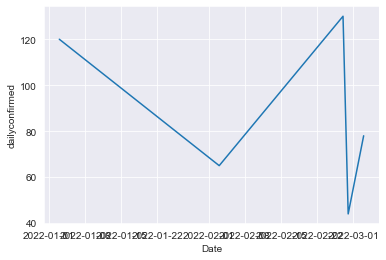

In [391]:
#plotting current data

sns.lineplot(x="Date", y="dailyconfirmed",legend = 'full' , data=train_df.tail(5))

In [392]:
train_df = train_df.set_index('Date')
train_df['dailyconfirmed'] = train_df['dailyconfirmed'].astype(float)

train_df.head()

,Unnamed: 0,dailyconfirmed
Date,,
2020-12-04,1,15.0
2020-04-13,2,33.0
2020-04-14,3,44.0
2020-04-15,4,55.0
2020-04-16,5,65.0


In [393]:
#Decomposing data to observe if there exists a sesional trend

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['dailyconfirmed'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15,20)

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [394]:
from statsmodels.tsa.stattools import adfuller #adfuller stands for Augmented Dickey-Fuller unit root test.

#The function find mean and standard deviation of the series and and performs augmented dickey fuller test.
#returns pvale .. The samaller the pvalue more stationary is the series.

def test_stationarity(timeseries, window = 15, cutoff = 0.01):
  rolmean = timeseries.rolling(window).mean()
  rolstd = timeseries.rolling(window).std()
  fig = plt.figure(figsize=(12, 8))
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC',)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  pvalue = dftest[1]
  if pvalue < cutoff:
      print('p-value = %.4f. The series is likely stationary.' % pvalue)
  else:
      print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
  
  print(dfoutput)

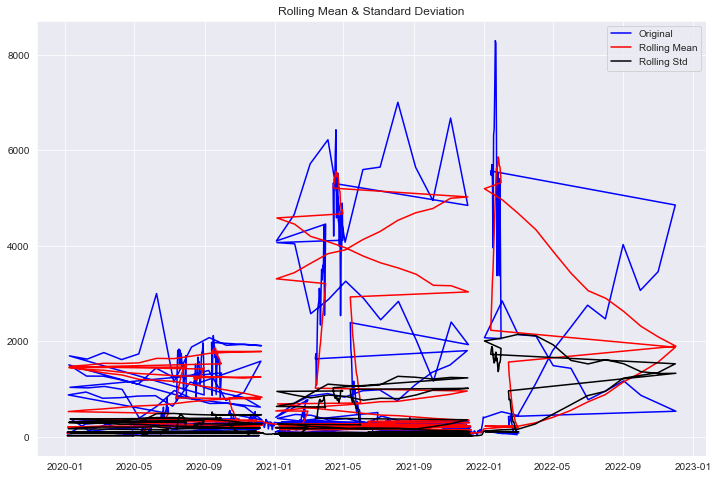

Results of Dickey-Fuller Test:
p-value = 0.0089. The series is likely stationary.
Test Statistic                  -3.465128
p-value                          0.008929
#Lags Used                      19.000000
Number of Observations Used    669.000000
Critical Value (1%)             -3.440163
Critical Value (5%)             -2.865870
Critical Value (10%)            -2.569076
dtype: float64


In [395]:
test_stationarity(train_df['dailyconfirmed'])

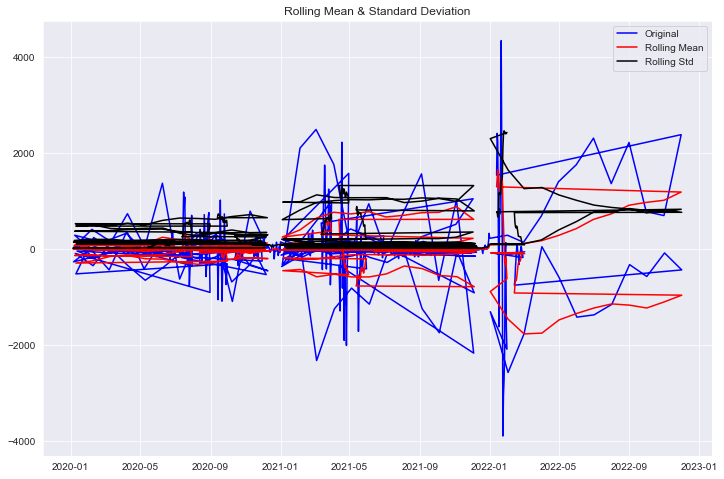

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.807089e+00
p-value                        2.162911e-09
#Lags Used                     1.900000e+01
Number of Observations Used    6.650000e+02
Critical Value (1%)           -3.440222e+00
Critical Value (5%)           -2.865896e+00
Critical Value (10%)          -2.569090e+00
dtype: float64


In [396]:
#here are various methods for making series stationary like log, differencing and so on..
#here we are using differencing , shift operator shifts the 'TT' cloumn of df by 4 places and difference is taken.

#plotting the data after differencing we see the pvalue is reduced to 0.3427 which is quite good as compared to our previous value 0.9778
#you can try different values in shift to reduce the pvalue (if possible , #try to choose one where number of observations used is MAX abd pval is MIN)

first_diff = train_df.dailyconfirmed - train_df.dailyconfirmed.shift(4)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

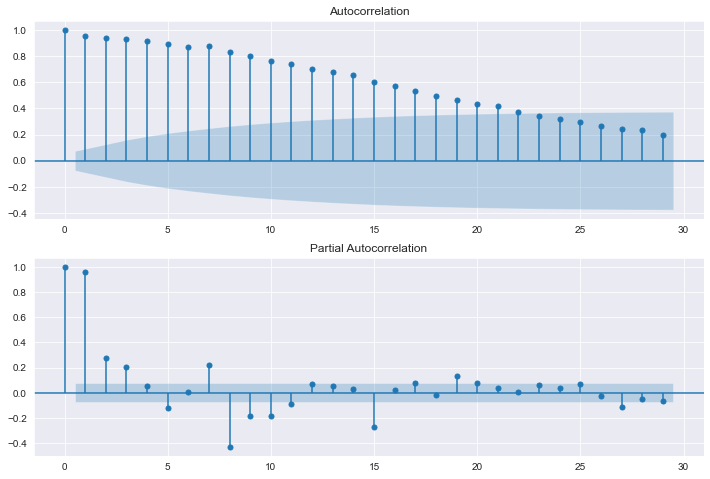

In [397]:
#plotting autocorrelation and partial autocorrelation for both data (data before differencing and data after differencing)

import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.dailyconfirmed, ax=ax1, ) # using default value of lag
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.dailyconfirmed, ax=ax2) # using default value of lag

In [398]:
# we can see a recurring correlation exists in both ACF and PACF hece we should choose SARIMAX model which also deals with seasonality

#RULE : A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that 
      #the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that 
      #the original series has a time-varying trend 

#Since our series has a contant average trend ( with growth ) we would take I = 1 and MA = 0 ( I-1 ).


sarimax_mod = sm.tsa.statespace.SARIMAX(train_df.dailyconfirmed, trend='n', order=(7,0,1)).fit()
print(sarimax_mod.summary())

                               SARIMAX Results                                
Dep. Variable:         dailyconfirmed   No. Observations:                  689
Model:               SARIMAX(7, 0, 1)   Log Likelihood               -5048.136
Date:                Sat, 05 Mar 2022   AIC                          10114.273
Time:                        21:27:23   BIC                          10155.090
Sample:                             0   HQIC                         10130.062
                                - 689                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1588      0.037      4.237      0.000       0.085       0.232
ar.L2          0.4927      0.031     15.907      0.000       0.432       0.553
ar.L3          0.2064      0.016     13.315      0.0

NormaltestResult(statistic=140.48514694664803, pvalue=3.119162104461638e-31)


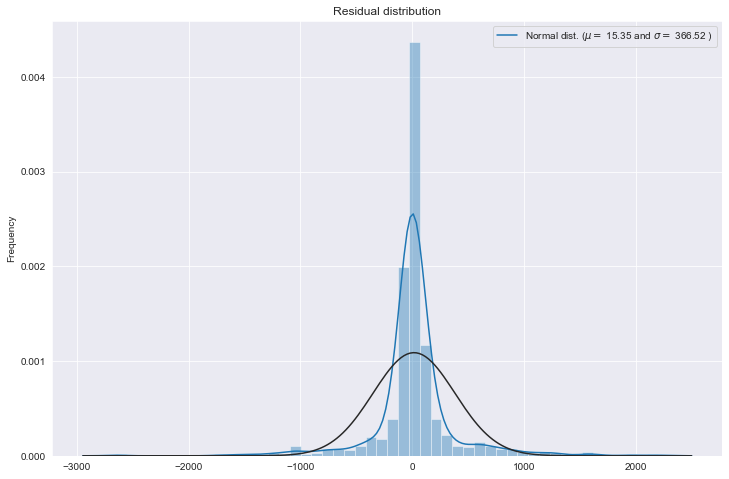

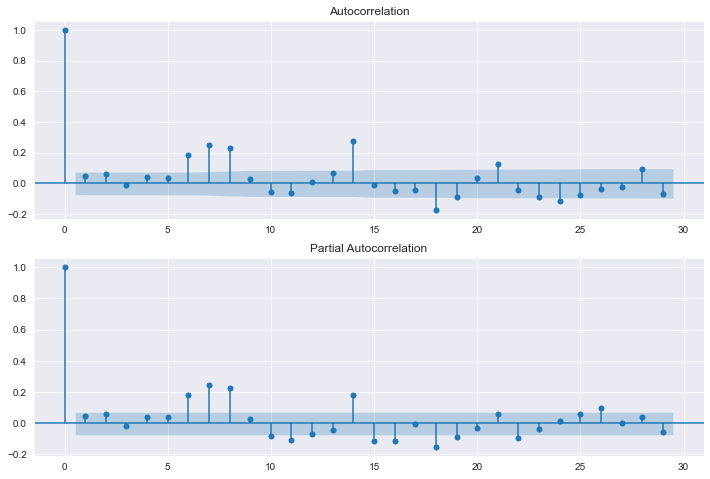

In [399]:
import scipy.stats as stats

resid = sarimax_mod.resid #gives residual degree of freedom (mu, sigma, pvalue ... )
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_mod.resid, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_mod.resid, ax=ax2)

In [400]:
last_row= train_df.index[-1]
last_row


Timestamp('2022-03-03 00:00:00')

In [415]:
last_row1 = pd.to_datetime(last_row).strftime('%d-%m-%Y')
last_row1

'03-03-2022'

In [430]:
# last_row1 = pd.to_datetime(last_row)
end_date = last_row+timedelta(days=8)
end_date=pd.to_datetime(end_date).strftime('%d-%m-%Y')
end_date

'11-03-2022'

<AxesSubplot:xlabel='Date'>

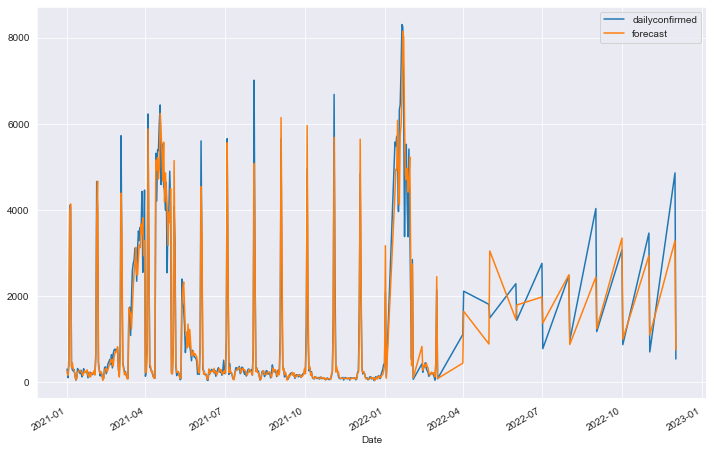

In [403]:
#Now lets predict using out model.
today = datetime.date.today() 

start_index = '1.1.2021'
end_index = today.strftime("%d-%m-%Y")

#adding forecasted values and plotting
train_df['forecast'] = sarimax_mod.predict(start= start_index,end ='3.3.2022',dynamic= False,)  

train_df[start_index:][['dailyconfirmed', 'forecast']].plot(figsize=(12, 8))

In [450]:
#lets predict for upcomming dates ..
future_predict = sarimax_mod.predict(start='3.3.2022',end=695)

In [451]:
future_predict

688     81.027772
689     76.661900
690    100.682524
691     96.036331
692     71.054832
693    103.992537
694     80.454686
695     88.654921
Name: predicted_mean, dtype: float64

In [445]:
date=train_df.index[-1]+timedelta(days=7)
date

Timestamp('2022-03-10 00:00:00')

In [95]:
start= datetime.date.today() -timedelta(days=3)
start

datetime.date(2022, 3, 2)

In [109]:
today = datetime.date.today() -timedelta(days=3)
today
end_index = today.strftime("%d-%m-%Y")
end_index

'02-03-2022'

In [117]:
train_df['forecast'] = sarimax_mod.predict(start= start_index,end =end_index,dynamic= False,)  
train_df['forecast']

Date
2020-12-04           NaN
2020-04-13           NaN
2020-04-14           NaN
2020-04-15           NaN
2020-04-16           NaN
                 ...    
2022-02-27    103.975868
2022-02-28     48.994966
2022-01-03    115.500195
2022-02-03    124.158273
2022-03-03    110.404745
Name: forecast, Length: 689, dtype: float64

In [349]:
from statsmodels.tsa.arima.model import ARIMA
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load dataset
series = train_df
# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

ValueError: SARIMAX models require univariate `endog`. Got shape (324, 3).

In [350]:
series = train_df
# seasonal difference
X = series.index
X

DatetimeIndex(['2020-12-04', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21',
               ...
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-02-28', '2022-01-03',
               '2022-02-03', '2022-03-03'],
              dtype='datetime64[ns]', name='Date', length=689, freq=None)